In [16]:
import numpy as np
import os
import camvid_data_manager as cdm
import segnet_model
import kaggle_data_generator as kdg
import utils
from keras.callbacks import TensorBoard
from utils import init_logging, log_debug, log_info, log_warning, log_critical, log_exception

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

## 1 Load segnet camvid model. (Model loaded with trained weights from the camvid image masking)
##   data.
%matplotlib inline

init_logging("image_segmentation.ini")

## 1. Load the model. If that fails due to lack of model information or weights, bail.
log_info("Current working directory is %s" %os.getcwd())




INFO:root:Current working directory is C:\Users\PAAV\Desktop\DL_Project\deep_learning_project\src


Logging level is  20


In [21]:
model = None
def load_model(optimizer = "optimizers.Adam(lr=0.0001)", weights = None):
    segnet_instance = segnet_model.SegnetModel("image_segmentation.ini", "Camvid")
    model = segnet_instance.load_model(optimizer, loss_type = segnet_model.LossType.CROSS_ENTROPY_LOSS, num_classes=12, weights = weights)
    if (model == None):
        log_warning("Failed to load model. Please train the model first before continuing further tests.")

    log_info("Loaded model successfully")
    return model

In [19]:
import cv2
from scipy import misc
import utils
import matplotlib.pyplot as plt
import shutil, random, os

%matplotlib inline

# https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/Segnet-Evaluation-Visualization.ipynb
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

# https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/Segnet-Evaluation-Visualization.ipynb
def convert_mask_to_rgb(mask):
    r = mask.copy()
    g = mask.copy()
    b = mask.copy()
    
    for l in range(0,11):
        r[mask==l]=label_colours[l,0]
        g[mask==l]=label_colours[l,1]
        b[mask==l]=label_colours[l,2]

    rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    return rgb

# Returns a random collection of image and mask paths of size |count|
def generate_image_and_mask_paths(folder, count):
    data_path = utils.get_config_value("image_segmentation.ini", "Camvid", "dataPath")
    seed = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    image_file_names = random.sample(os.listdir(data_path + "/" + folder), count)

    image_paths = []
    mask_paths = []
    for image_file_name in image_file_names:
        image_paths.append(data_path + "/" + folder + "/" + image_file_name)
        mask_paths.append(data_path + "/" + folder + "annot/" + image_file_name)
    
    return image_paths, mask_paths

# Helper function to test #count images in the |folder|. The function loads the images and
# calls the predict() function on the model loaded above. The returned mask from predict is plotted
# along with the image, actual mask and the predicted mask.
def test_images(folder, count):
    data_path = utils.get_config_value("image_segmentation.ini", "Camvid", "dataPath")
    image_width = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageWidth"))
    image_height = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageHeight"))
    seed = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    log_info("Image width %d, Image height %d" %(image_width, image_height))
    log_info("datapath %s" %(data_path))

    image_paths, mask_paths = generate_image_and_mask_paths(folder, count)
    
    for i in range(0, len(image_paths)):
        image_path = image_paths[i]
        log_info("Image path is %s" %image_path)
        image = misc.imread(image_path)
        image = cv2.resize(image, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255

        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        mask = np.argmax(predicted, axis = -1)
        mask = np.asarray(convert_mask_to_rgb(np.squeeze(mask)))
        
        original_mask = misc.imread(mask_paths[i])
        original_mask = cv2.resize(original_mask, (image_width, image_height))
        original_mask = np.asarray(convert_mask_to_rgb(np.squeeze(original_mask)))

        images = []
        cmaps = []

        images.append(image)
        images.append(original_mask)
        images.append(mask)
        
        cmaps.append(None)
        cmaps.append(None)
        cmaps.append(None)        

        utils.plot_images(images, cmaps)    


INFO:root:Config values read from ini file are
INFO:root:Data path is ../../CamVid. Image Width 256, Image Height 256
INFO:root:Done printing config values
INFO:root:file pathe ../../CamVid/train.txt
INFO:root:Train Image ids length is  367
INFO:root:Image path is ../../CamVid/train 
INFO:root:total images are 367 


Logging level is  20


INFO:root:Returning training images
INFO:root:Total training images is 367
INFO:root:Image path is ../../CamVid/trainannot 
INFO:root:total images are 367 
INFO:root:Returning training images
INFO:root:Total training images in list is 367
INFO:root:file pathe ../../CamVid/val.txt
INFO:root:Val Image ids length is  101
INFO:root:Image path is ../../CamVid/val 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation images is 101
INFO:root:Image path is ../../CamVid/valannot 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation mask images in list is 101
INFO:root:file pathe ../../CamVid/test.txt
INFO:root:Test image ids length is  233
INFO:root:Image path is ../../CamVid/test 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:Total testing images is 233
INFO:root:Image path is ../../CamVid/testannot 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:To

Logging level is  20


INFO:root:
Loading weights from file ../../CamVid/camvid/camvid_image_segmentation_nn_weighted.h5
INFO:root:Using weighted sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully
INFO:root:Testing images from the Camvid test folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath ../../CamVid
INFO:root:Image path is ../../CamVid/test/Seq05VD_f03270.png
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


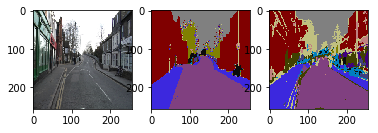

INFO:root:Image path is ../../CamVid/test/Seq05VD_f04350.png
INFO:root:In plot_images. Total images 3


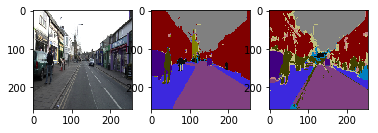

INFO:root:Image path is ../../CamVid/test/Seq05VD_f04110.png
INFO:root:In plot_images. Total images 3


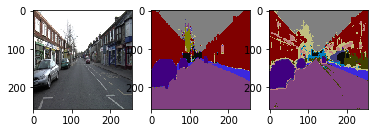

INFO:root:Image path is ../../CamVid/test/Seq05VD_f02970.png
INFO:root:In plot_images. Total images 3


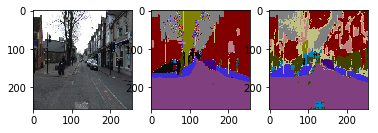

INFO:root:Image path is ../../CamVid/test/0001TP_009660.png
INFO:root:In plot_images. Total images 3


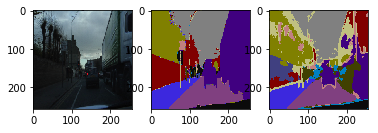

INFO:root:Done with train image tests


In [23]:
import numpy as np
import os
import camvid_data_manager as cdm
import utils

camvid_data_manager = cdm.CamvidDataManager("image_segmentation.ini")
model = load_model(weights = camvid_data_manager.get_class_weights())
print(model)
import cv2
from scipy import misc
%matplotlib inline

## 2. Testing test images with hyperparameters of Adam with learning rate of 0.0001, with class weight, image size of 
##    256 x 256 x 3 and batch size of 4. Validation categorical accuracy of 0.8114%
log_info("Testing images from the Camvid test folder")

test_images("test", 5)
    
log_info("Done with train image tests")

INFO:root:Config values read from ini file are
INFO:root:Data path is ../../CamVid. Image Width 256, Image Height 256
INFO:root:Done printing config values
INFO:root:file pathe ../../CamVid/train.txt
INFO:root:Train Image ids length is  367
INFO:root:Image path is ../../CamVid/train 
INFO:root:total images are 367 


Logging level is  20


INFO:root:Returning training images
INFO:root:Total training images is 367
INFO:root:Image path is ../../CamVid/trainannot 
INFO:root:total images are 367 
INFO:root:Returning training images
INFO:root:Total training images in list is 367
INFO:root:file pathe ../../CamVid/val.txt
INFO:root:Val Image ids length is  101
INFO:root:Image path is ../../CamVid/val 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation images is 101
INFO:root:Image path is ../../CamVid/valannot 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation mask images in list is 101
INFO:root:file pathe ../../CamVid/test.txt
INFO:root:Test image ids length is  233
INFO:root:Image path is ../../CamVid/test 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:Total testing images is 233
INFO:root:Image path is ../../CamVid/testannot 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:To

Logging level is  20


INFO:root:
Loading weights from file ../../CamVid/camvid/camvid_image_segmentation_nn_weighted_sgd.h5
INFO:root:Using weighted sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully
INFO:root:Testing images from the Camvid test folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath ../../CamVid
INFO:root:Image path is ../../CamVid/test/0001TP_009090.png
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


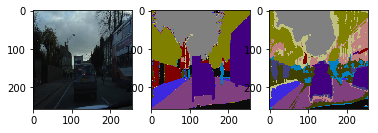

INFO:root:Image path is ../../CamVid/test/0001TP_009120.png
INFO:root:In plot_images. Total images 3


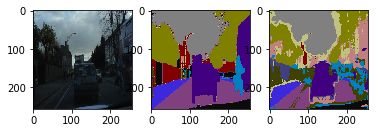

INFO:root:Image path is ../../CamVid/test/Seq05VD_f00210.png
INFO:root:In plot_images. Total images 3


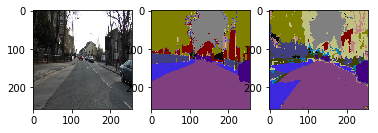

INFO:root:Image path is ../../CamVid/test/Seq05VD_f03480.png
INFO:root:In plot_images. Total images 3


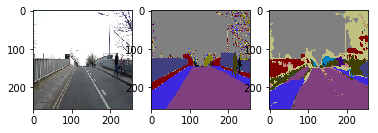

INFO:root:Image path is ../../CamVid/test/Seq05VD_f01800.png
INFO:root:In plot_images. Total images 3


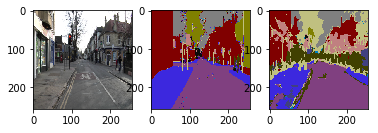

INFO:root:Done with train image tests


In [25]:
import numpy as np
import os
import camvid_data_manager as cdm
import utils

camvid_data_manager = cdm.CamvidDataManager("image_segmentation.ini")
model =load_model("optimizers.SGD(lr=0.1, momentum=0.9)", weights = camvid_data_manager.get_class_weights())
print(model)
import cv2
from scipy import misc
%matplotlib inline

## Testing test images with hyperparameters of SGD(lr=0.1, momentum=0.9), with class weight, image size of 
##    256 x 256 x 3 and batch size of 4. Validation categorical accuracy of 0.7462
log_info("Testing images from the Camvid test folder")

test_images("test", 5)
    
log_info("Done with train image tests")

INFO:root:Testing images from the Camvid train folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_01050.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


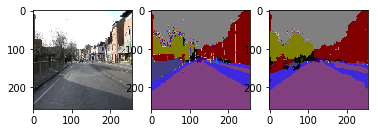

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_05220.png
INFO:root:In plot_images. Total images 3


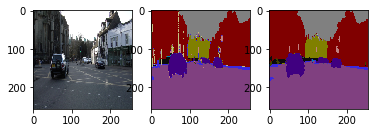

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_07320.png
INFO:root:In plot_images. Total images 3


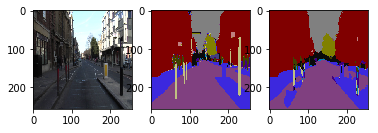

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0001TP_007830.png
INFO:root:In plot_images. Total images 3


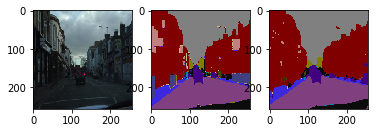

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train/0016E5_06510.png
INFO:root:In plot_images. Total images 3


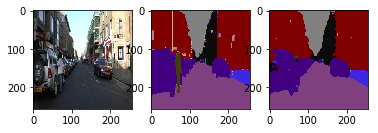

INFO:root:Done with train image tests


In [4]:
##  Testing training images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline


log_info("Testing images from the Camvid train folder")

test_images("train", 5)
    
log_info("Done with train image tests")


INFO:root:Testing images from the Camvid validation folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08157.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


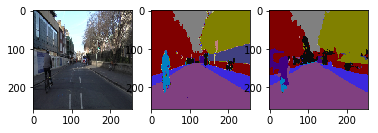

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08139.png
INFO:root:In plot_images. Total images 3


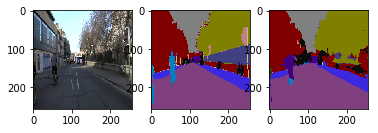

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08045.png
INFO:root:In plot_images. Total images 3


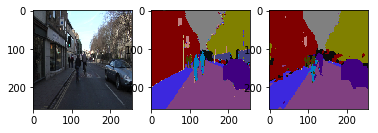

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_07987.png
INFO:root:In plot_images. Total images 3


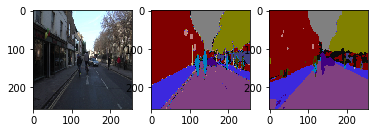

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val/0016E5_08115.png
INFO:root:In plot_images. Total images 3


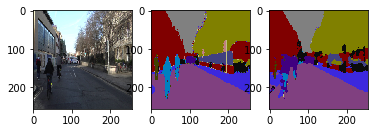

INFO:root:Done with tests


In [5]:
## 3. Testing validation images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline
log_info("Testing images from the Camvid validation folder")

test_images("val", 5)
    
log_info("Done with tests")

INFO:root:Testing images from the Camvid test folder
INFO:root:Image width 256, Image height 256
INFO:root:datapath /home/ubuntu/illinois/SegNet-Tutorial/CamVid
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f00000.png
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:In plot_images. Total images 3


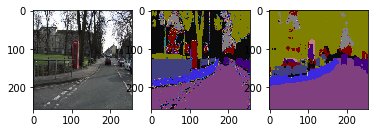

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/0001TP_009690.png
INFO:root:In plot_images. Total images 3


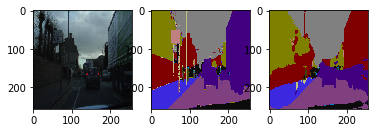

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/0001TP_009660.png
INFO:root:In plot_images. Total images 3


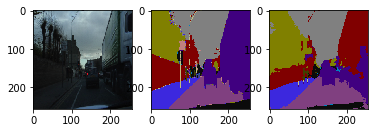

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/0001TP_009630.png
INFO:root:In plot_images. Total images 3


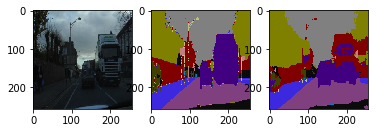

INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test/Seq05VD_f01560.png
INFO:root:In plot_images. Total images 3


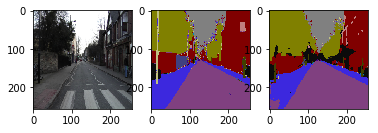

INFO:root:Done with tests


In [6]:
## 4. Testing test images with hyperparameters of Adam with learning rate of 0.0001, image size of 
##    256 x 256 x 3 and batch size of 4. Validation accuracy of 0.8336%
import cv2
from scipy import misc
%matplotlib inline
log_info("Testing images from the Camvid test folder")

test_images("test", 5)
    
log_info("Done with tests")

In [29]:
## 5. Testing one of the videos in the Camvid data set with hyperparameters of Adam with 
##    learning rate of 0.0001, image size of  256 x 256 x 3 and batch size of 4. 
##    Validation accuracy of 0.8336%

# The video 0005VD.mxf was downloaded from here ftp://svr-ftp.eng.cam.ac.uk/pub/eccv/
# and converted to AVI format.

import cv2
import matplotlib.pyplot as plt
from IPython import display
import utils
import numpy as np

utils.init_logging("image_segmentation.ini")

data_path = utils.get_config_value("image_segmentation.ini", "Camvid", "dataPath")
image_width = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageWidth"))
image_height = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageHeight"))

utils.log_info("Image width %d, Image height %d" %(image_width, image_height))

vid = cv2.VideoCapture(data_path + "/videos/" + '0006R0.avi')
# Check if camera opened successfully
if (vid.isOpened()== False): 
  print("Error opening video stream or file")

frame_count = 0

try:
    while (True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            print("Released video resource")
            break

        image = cv2.resize(frame, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255
        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        mask = np.argmax(predicted, axis = -1)

        images = []
        cmaps = []
        
        mask = np.asarray(convert_mask_to_rgb(np.squeeze(mask)))
        
        images.append(image)
        images.append(mask)
        cmaps.append(None)
        cmaps.append(None)
        
        #utils.plot_images(images, cmaps, False)
        
        plot = plt.figure()
        for i in range(len(images)):
           plot.add_subplot(1, 2, i + 1)
           image = np.squeeze(images[i])
           if (cmaps[i] == 'gray'):
               image = image.astype(np.uint8)
           plt.imshow(image, cmap = cmaps[i])
        
        display.display(plt.gcf())
        display.clear_output(wait = True)
        plt.close()
        frame_count = frame_count + 1
        if (frame_count == 100):
            print("Read 100 frames. Exiting")
            vid.release()
            break
        
except KeyboardInterrupt:
    vid.release()
    print("Released video resource")


Read 100 frames. Exiting


In [14]:
import cv2
from scipy import misc
%matplotlib inline


def populate_original_and_predicted_masks(folder):
    data_path = utils.get_config_value("image_segmentation.ini", "Camvid", "dataPath")
    image_width = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageWidth"))
    image_height = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageHeight"))
    seed = int(utils.get_config_value("image_segmentation.ini", "Camvid", "imageAugmentationSeed"))
    log_info("Image width %d, Image height %d" %(image_width, image_height))
    log_info("datapath %s" %(data_path))
    
    original_mask = []
    predicted_masks = []
    for image_path in os.listdir(data_path + "/" + folder):
        
        image = misc.imread(data_path + "/" + folder + "/" + image_path)
        image = cv2.resize(image, (image_width, image_height))
        image_normalized = np.array(image, np.float32) / 255
        predicted = model.predict(np.expand_dims(image_normalized, axis = 0))
        predicted_mask = np.argmax(predicted, axis = -1)
        predicted_masks.append(predicted_mask)
        
        original_mask_folder = folder + "annot"
        image_original_mask = misc.imread(data_path + "/" + original_mask_folder + "/" + image_path)
        image_original_mask = cv2.resize(image_original_mask, (image_width, image_height))
        
        original_mask.append(image_original_mask)


    return  original_mask, predicted_masks



In [6]:
from sklearn.metrics import classification_report
def camvid_classification_report():
    predicted = []
    actual = []
    for i in range(len(predicted_masks)):
        p = np.array(predicted_masks[i])
        a = np.array(original_mask[i]) 
        predicted.extend( np.reshape(p, (np.product(p.shape),)))
        actual.extend( np.reshape(a, (np.product(a.shape),)))
    target_names = ["Sky", "Building", "Pole", "Road", "Pavement", "Tree", "SignSymbol", "Fence", "Car", "Pedestrian", "Bicyclist", "Unlabelled"]
    log_info(classification_report(actual,predicted, target_names=target_names))

In [4]:
#Report with car_image_segmentation_nn
camvid_classification_report()

INFO:root:              precision    recall  f1-score   support

         Sky       0.95      0.94      0.94   2509917
    Building       0.76      0.70      0.73   3755562
        Pole       0.41      0.04      0.08    211384
        Road       0.92      0.94      0.93   4005260
    Pavement       0.84      0.73      0.78   1453818
        Tree       0.61      0.82      0.70   1677843
  SignSymbol       0.19      0.09      0.13    177336
       Fence       0.10      0.27      0.14    206297
         Car       0.85      0.72      0.78    620953
  Pedestrian       0.30      0.17      0.22    111261
   Bicyclist       0.19      0.02      0.03     60627
  Unlabelled       0.38      0.36      0.37    479630

   micro avg       0.78      0.78      0.78  15269888
   macro avg       0.54      0.48      0.49  15269888
weighted avg       0.79      0.78      0.78  15269888



In [12]:
#Report with camvid_image_segmentation_nn
camvid_classification_report()

INFO:root:              precision    recall  f1-score   support

         Sky       0.96      0.94      0.95   2509917
    Building       0.85      0.72      0.78   3755562
        Pole       0.34      0.07      0.12    211384
        Road       0.89      0.96      0.92   4005260
    Pavement       0.83      0.64      0.72   1453818
        Tree       0.62      0.84      0.72   1677843
  SignSymbol       0.30      0.16      0.21    177336
       Fence       0.17      0.40      0.24    206297
         Car       0.74      0.82      0.78    620953
  Pedestrian       0.33      0.31      0.32    111261
   Bicyclist       0.27      0.21      0.24     60627
  Unlabelled       0.41      0.38      0.40    479630

   micro avg       0.79      0.79      0.79  15269888
   macro avg       0.56      0.54      0.53  15269888
weighted avg       0.80      0.79      0.79  15269888



In [21]:
#Report with camvid_image_segmentation_nn_weighted
import numpy as np
import os
import camvid_data_manager as cdm
import utils

camvid_data_manager = cdm.CamvidDataManager("image_segmentation.ini")
model = load_model(weights = camvid_data_manager.get_class_weights())
original_mask,  predicted_masks = populate_original_and_predicted_masks("test")
camvid_classification_report()

INFO:root:Config values read from ini file are
INFO:root:Data path is ../../CamVid. Image Width 256, Image Height 256
INFO:root:Done printing config values
INFO:root:file pathe ../../CamVid/train.txt
INFO:root:Train Image ids length is  367
INFO:root:Image path is ../../CamVid/train 
INFO:root:total images are 367 


Logging level is  20


INFO:root:Returning training images
INFO:root:Total training images is 367
INFO:root:Image path is ../../CamVid/trainannot 
INFO:root:total images are 367 
INFO:root:Returning training images
INFO:root:Total training images in list is 367
INFO:root:file pathe ../../CamVid/val.txt
INFO:root:Val Image ids length is  101
INFO:root:Image path is ../../CamVid/val 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation images is 101
INFO:root:Image path is ../../CamVid/valannot 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation mask images in list is 101
INFO:root:file pathe ../../CamVid/test.txt
INFO:root:Test image ids length is  233
INFO:root:Image path is ../../CamVid/test 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:Total testing images is 233
INFO:root:Image path is ../../CamVid/testannot 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:To

Logging level is  20


INFO:root:
Loading weights from file ../../CamVid/camvid/camvid_image_segmentation_nn_weighted.h5
INFO:root:Using weighted sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully
INFO:root:Image width 256, Image height 256
INFO:root:datapath ../../CamVid
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:              precision    recall  f1-score   support

         Sky       0.98      0.81      0.89   2509917
    Building       0.81      0.43      0.56   3755562
        Pole       0.05      0.49      0.09    211384
        Road       0.99      0.81      0.89   4005260
    P

In [20]:
#Report with camvid_image_segmentation_nn_sgd
import numpy as np
import os
import camvid_data_manager as cdm
import utils
model = load_model("optimizers.SGD(lr=0.1, momentum=0.9)")
original_mask,  predicted_masks = populate_original_and_predicted_masks("test")
camvid_classification_report()

INFO:root:Total number of gpus 0
INFO:root:
Opened model file ../../CamVid/camvid/camvid_image_segmentation_nn_sgd.json


Logging level is  20


INFO:root:
Loading weights from file ../../CamVid/camvid/camvid_image_segmentation_nn_sgd.h5
INFO:root:Using sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully
INFO:root:Image width 256, Image height 256
INFO:root:datapath ../../CamVid
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:              precision    recall  f1-score   support

         Sky       0.94      0.96      0.95   2509917
    Building       0.82      0.75      0.78   3755562
        Pole       0.28      0.09      0.13    211384
        Road       0.88      0.96      0.92   4005260
    Pavement       

In [17]:
#Report with camvid_image_segmentation_nn_weighted_sgd
import numpy as np
import os
import camvid_data_manager as cdm
import utils

camvid_data_manager = cdm.CamvidDataManager("image_segmentation.ini")
model =load_model("optimizers.SGD(lr=0.1, momentum=0.9)", weights = camvid_data_manager.get_class_weights())

INFO:root:Config values read from ini file are
INFO:root:Data path is ../../CamVid. Image Width 256, Image Height 256
INFO:root:Done printing config values
INFO:root:file pathe ../../CamVid/train.txt
INFO:root:Train Image ids length is  367
INFO:root:Image path is ../../CamVid/train 
INFO:root:total images are 367 


Logging level is  20


INFO:root:Returning training images
INFO:root:Total training images is 367
INFO:root:Image path is ../../CamVid/trainannot 
INFO:root:total images are 367 
INFO:root:Returning training images
INFO:root:Total training images in list is 367
INFO:root:file pathe ../../CamVid/val.txt
INFO:root:Val Image ids length is  101
INFO:root:Image path is ../../CamVid/val 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation images is 101
INFO:root:Image path is ../../CamVid/valannot 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation mask images in list is 101
INFO:root:file pathe ../../CamVid/test.txt
INFO:root:Test image ids length is  233
INFO:root:Image path is ../../CamVid/test 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:Total testing images is 233
INFO:root:Image path is ../../CamVid/testannot 
INFO:root:total images are 233 
INFO:root:Returning training images
INFO:root:To

Logging level is  20


INFO:root:
Loading weights from file ../../CamVid/camvid/camvid_image_segmentation_nn_weighted_sgd.h5
INFO:root:Using weighted sparse_categorical_crossentropy as the loss function
INFO:root:Loaded model successfully


In [19]:
original_mask,  predicted_masks = populate_original_and_predicted_masks("test")
camvid_classification_report()

INFO:root:Image width 256, Image height 256
INFO:root:datapath ../../CamVid
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\PAAV\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
INFO:root:              precision    recall  f1-score   support

         Sky       0.98      0.85      0.91   2509917
    Building       0.93      0.30      0.46   3755562
        Pole       0.05      0.48      0.09    211384
        Road       0.96      0.83      0.89   4005260
    Pavement       0.88      0.65      0.75   1453818
        Tree       0.85      0.47      0.61   1677843
  SignSymbol       0.07      0.56      0.13    177336
       Fence       0.11      0.36      0.17    206297
 